In [12]:
import arff
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
%matplotlib inline

In [3]:
dataset = arff.load(open('./TrainingDataset.arff'))
att_list = []
for att in dataset['attributes']:
    att_list.append(att[0])
Traindata = np.array(dataset['data'])
Traindata = pd.DataFrame(Traindata, columns=att_list)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [4]:
target = Traindata.values[:, len(Traindata.columns) - 1]
# target = target.astype('int')
Traindata.drop('Result', axis=1, inplace=True)

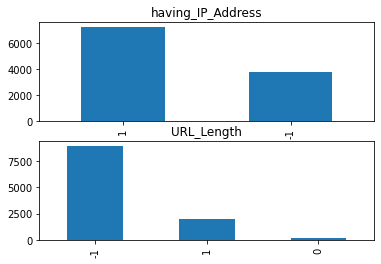

In [5]:
Traindata_visual = Traindata.copy()
plt.subplot(2, 1, 1)
pd.value_counts(Traindata_visual['having_IP_Address']).plot.bar()
plt.title('having_IP_Address')
plt.subplot(2, 1, 2)
pd.value_counts(Traindata_visual['URL_Length']).plot.bar()
plt.title('URL_Length')
plt.show()

In [6]:
scaler = StandardScaler()
scaler.fit(Traindata)
Traindata = pd.DataFrame(scaler.transform(Traindata), index=Traindata.index, columns=Traindata.columns)

feature = Traindata.values

feature, feature_test, target, target_test = train_test_split(feature, target, test_size = 0.2, random_state = 42)

In [9]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# Build Pipeline 
# Pass our pipeline in to GridSearchCV can help us to tuning hypermeter with K-Fold cross validation
pipe = Pipeline([
    ('feature_selection', PCA()),
    ('model', KNeighborsClassifier(algorithm='kd_tree'))])

param_grid = {
    'feature_selection__n_components':[2, 4, 6, 8, 10, 12, 14],
    'model__n_neighbors': [1, 3, 5, 7, 9],
    'model__p':[1,2]
}

best_knn = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=32)
#train forest model
best_knn.fit(feature,target)

target_pred_knn = best_knn.predict(feature)
print("Best max_features:",best_knn.best_estimator_.get_params()['steps'][0][1].n_components)
print("Best n_neighbor:",best_knn.best_estimator_.get_params()['steps'][1][1].n_neighbors)
print("Best Power parameter for the Minkowski metric:",best_knn.best_estimator_.get_params()['steps'][1][1].p)
print("Confusion matrix:")
class_list = ['Non-Phishing','Phishing']
row_format ="{:>15}" * (len(class_list) + 1)

print(row_format.format("", *class_list))
for team, row in zip(class_list, confusion_matrix(target,target_pred_knn)):
    print(row_format.format(team, *row))
print(classification_report(target, target_pred_knn,target_names=class_list))
print("Misclassified sample: %d" % (target != target_pred_knn).sum())

Best max_features: 8
Best n_neighbor: 1
Best Power parameter for the Minkowski metric: 2
Confusion matrix:
                  Non-Phishing       Phishing
   Non-Phishing           3889             53
       Phishing             53           4849
              precision    recall  f1-score   support

Non-Phishing       0.99      0.99      0.99      3942
    Phishing       0.99      0.99      0.99      4902

    accuracy                           0.99      8844
   macro avg       0.99      0.99      0.99      8844
weighted avg       0.99      0.99      0.99      8844

Misclassified sample: 106


In [20]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# Build Pipeline 
# Pass our pipeline in to GridSearchCV can help us to tuning hypermeter with K-Fold cross validation
pipe = Pipeline([
    ('model', MLPClassifier())])

param_grid = {
    'model__hidden_layer_sizes':[(16,),(32,),(64,),(128,),(16,4),(32,8),(64,16,4),(128,64,16)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver':['lbfgs', 'sgd', 'adam'],
    'model__learning_rate':['constant', 'invscaling', 'adaptive'],
    'model__learning_rate_init':[0.01,0.001]
}

best_mlp = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=8)
#train forest model
best_mlp.fit(feature,target)

target_pred_mlp = best_mlp.predict(feature)
print("Best max_features:",best_mlp.best_estimator_.get_params()['steps'][0][1].hidden_layer_sizes)
print("Best n_neighbor:",best_mlp.best_estimator_.get_params()['steps'][0][1].activation)
print("Best n_neighbor:",best_mlp.best_estimator_.get_params()['steps'][0][1].solver)
print("Best n_neighbor:",best_mlp.best_estimator_.get_params()['steps'][0][1].learning_rate)
print("Best n_neighbor:",best_mlp.best_estimator_.get_params()['steps'][0][1].learning_rate_init)

print("Confusion matrix:")
class_list = ['Non-Phishing','Phishing']
row_format ="{:>15}" * (len(class_list) + 1)

print(row_format.format("", *class_list))
for team, row in zip(class_list, confusion_matrix(target,target_pred_mlp)):
    print(row_format.format(team, *row))
print(classification_report(target, target_pred_mlp,target_names=class_list))
print("Misclassified sample: %d" % (target != target_pred_mlp).sum())

Best max_features: (128,)
Best n_neighbor: logistic
Best n_neighbor: adam
Best n_neighbor: constant
Best n_neighbor: 0.01
Confusion matrix:
                  Non-Phishing       Phishing
   Non-Phishing           3856             86
       Phishing              9           4893
              precision    recall  f1-score   support

Non-Phishing       1.00      0.98      0.99      3942
    Phishing       0.98      1.00      0.99      4902

    accuracy                           0.99      8844
   macro avg       0.99      0.99      0.99      8844
weighted avg       0.99      0.99      0.99      8844

Misclassified sample: 95
